In [24]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

# Variational Autoencoder

Go from input dim to a small tensor of gaussians parameterized by mu and sigma and then build out to the larger output dim (equal to input dim).

Later, sample from the gaussian distribution to interpolate within the distribution learn by the VAE.

---

Example: Train on emojis and then sample novel emojis.

In [25]:
from flax import nnx

In [26]:
class Encoder(nnx.Module):
    def __init__(self, input_dim: (int, int), *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(input_dim[0] * input_dim[1], 
                                  input_dim[0] * input_dim[1] // 8, 
                                  rngs=rngs)
        self.linear2 = nnx.Linear(input_dim[0] * input_dim[1] // 8,
                                  input_dim[0] * input_dim[1] // 64,
                                  rngs=rngs)
        self.linear3 = nnx.Linear(input_dim[0] * input_dim[1] // 64,
                                  2,
                                  rngs=rngs)
        self.dropout = nnx.Dropout(0.2, rngs=rngs)

    def __call__(self, input):
        x = nnx.relu(self.dropout(self.linear1(input)))
        x = nnx.relu(self.dropout(self.linear2(x)))
        x = nnx.relu(self.dropout(self.linear3(x)))

In [27]:
class Decoder(nnx.Module):
    def __init__(self, input_dim: (int, int), *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(input_dim[0] * input_dim[1], 
                                  input_dim[0] * input_dim[1] // 8, 
                                  rngs=rngs)
        self.linear2 = nnx.Linear(input_dim[0] * input_dim[1] // 8,
                                  input_dim[0] * input_dim[1] // 64,
                                  rngs=rngs)
        self.linear3 = nnx.Linear(input_dim[0] * input_dim[1] // 64,
                                  2,
                                  rngs=rngs)
        self.dropout = nnx.Dropout(0.2, rngs=rngs)

    def __call__(self, input):
        x = nnx.relu(self.dropout(self.linear3(input)))
        x = nnx.relu(self.dropout(self.linear2(x)))
        x = nnx.relu(self.dropout(self.linear1(x)))

In [38]:
class Autoencoder(nnx.Module):
    def __init__(self, input_dim: (int, int), *, rngs: nnx.Rngs):
        self.encode = Encoder(input_dim=input_dim, rngs=rngs)
        self.decode = Decoder(input_dim=input_dim, rngs=rngs)

    def __call__(self):
        pass

rngs = nnx.Rngs(0)
Autoencoder(input_dim=(128, 128), rngs=rngs)

Autoencoder( # RngState: 2 (12 B), Param: 68,163,076 (272.7 MB), Total: 68,163,078 (272.7 MB)
  encode=Encoder( # Param: 34,081,538 (136.3 MB)
    linear1=Linear( # Param: 33,556,480 (134.2 MB)
      kernel=Param( # 33,554,432 (134.2 MB)
        value=Array(shape=(16384, 2048), dtype=dtype('float32'))
      ),
      bias=Param( # 2,048 (8.2 KB)
        value=Array(shape=(2048,), dtype=dtype('float32'))
      ),
      in_features=16384,
      out_features=2048,
      use_bias=True,
      dtype=None,
      param_dtype=float32,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x7bb871c95d00>,
      bias_init=<function zeros at 0x7bb87288f100>,
      dot_general=<function dot_general at 0x7bb8d01818a0>,
      promote_dtype=<function promote_dtype at 0x7bb871c95580>
    ),
    linear2=Linear( # Param: 524,544 (2.1 MB)
      kernel=Param( # 524,288 (2.1 MB)
        value=Array(shape=(2048, 256), dtype=dtype('float32'))
      ),
      bias=Param( # 256 (1.0 

In [39]:
from datasets import load_dataset

In [40]:
dataset = load_dataset("valhalla/emoji-dataset", split="train").with_format("jax")

In [41]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 2749
})

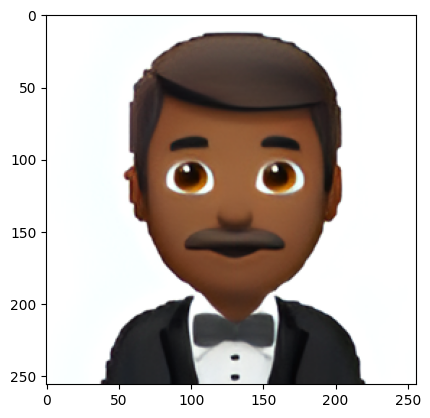

In [36]:
for batch in dataset.iter(batch_size=32):
    # print(batch["image"])
    plt.imshow(batch["image"][0])